In [1]:
import numpy as np
from scipy import integrate
import tensornetwork as tn
import tensorflow as tf
import qriemannopt as qro
from MERAOpt import MERAOpt
import matplotlib.pyplot as plt
from tqdm import tqdm
tn.set_default_backend("tensorflow")

### Auxiliary functions (Mera layer, generators for disentanglers and isometries)

In [2]:
@tf.function
def mera_layer(H,
               U,
               U_conj,
               Z_left,
               Z_right,
               Z_left_conj,
               Z_right_conj):
    """
    Returns two-side hamiltonian after renormalization.
    Args:
        H: complex valued tf tensor of shape (chi ** 2, chi ** 2), two-side hamiltonian
        U: complex valued tf tensor of shape (chi ** 2, chi ** 2), disentangler
        U_conj: complex valued tf tensor of shape (chi ** 2, chi ** 2), conjugated disentangler
        Z_left: complex valued tf tensor of shape (chi ** 3, new_chi), left isometry
        Z_right: complex valued tf tensor of shape (chi ** 3, new_chi), right isometry
        Z_left_conj: complex valued tf tensor of shape (chi ** 3, new_chi), left conjugated isometry
        Z_right_conj: complex valued tf tensor of shape (chi ** 3, new_chi), right conjugated isometry
    Returns: 
        tf tensor of shape (new_chi ** 2, new_chi ** 2), renormalized two side hamiltonian
    """
    
    # chi and new_chi
    chi = tf.cast(tf.math.sqrt(tf.cast(U.shape[0], dtype=tf.float64)), dtype=tf.int32)
    chi_new = Z_left.shape[-1]
    
    # tn nodes
    h = tn.Node(tf.reshape(H, (chi, chi, chi, chi)))
    u = tn.Node(tf.reshape(U, (chi, chi, chi, chi)))
    u_conj = tn.Node(tf.reshape(U_conj, (chi, chi, chi, chi)))
    z_left = tn.Node(tf.reshape(Z_left, (chi, chi, chi, chi_new)))
    z_right = tn.Node(tf.reshape(Z_right, (chi, chi, chi, chi_new)))
    z_left_conj = tn.Node(tf.reshape(Z_left_conj, (chi, chi, chi, chi_new)))
    z_right_conj = tn.Node(tf.reshape(Z_right_conj, (chi, chi, chi, chi_new)))
    
    # standard for all parts environment
    z_left[0]^z_left_conj[0]
    z_right[2]^z_right_conj[2]
    u[2]^z_left[2]
    u[3]^z_right[0]
    u_conj[2]^z_left_conj[2]
    u_conj[3]^z_right_conj[0]
    
    # first renormalization
    z_left[1]^h[2]
    z_left_conj[1]^h[0]
    u[0]^h[3]
    u_conj[0]^h[1]
    u[1]^u_conj[1]
    z_right[1]^z_right_conj[1]
    nodes = tn.reachable(h)
    renorm_first = tn.contractors.optimal(nodes, [z_left_conj[3],
                                                  z_right_conj[3],
                                                  z_left[3],
                                                  z_right[3]])
    
    # standard for all parts environment
    z_left[0]^z_left_conj[0]
    z_right[2]^z_right_conj[2]
    u[2]^z_left[2]
    u[3]^z_right[0]
    u_conj[2]^z_left_conj[2]
    u_conj[3]^z_right_conj[0]
    
    # second renormalization
    z_left[1]^z_left_conj[1]
    z_right[1]^z_right_conj[1]
    u[0]^h[2]
    u[1]^h[3]
    u_conj[0]^h[0]
    u_conj[1]^h[1]
    nodes = tn.reachable(h)
    renorm_second = tn.contractors.optimal(nodes, [z_left_conj[3],
                                                  z_right_conj[3],
                                                  z_left[3],
                                                  z_right[3]])
    
    # standard for all parts environment
    z_left[0]^z_left_conj[0]
    z_right[2]^z_right_conj[2]
    u[2]^z_left[2]
    u[3]^z_right[0]
    u_conj[2]^z_left_conj[2]
    u_conj[3]^z_right_conj[0]
    
    # third renormalization
    z_left[1]^z_left_conj[1]
    u[0]^u_conj[0]
    u[1]^h[2]
    u_conj[1]^h[0]
    z_right[1]^h[3]
    z_right_conj[1]^h[1]
    nodes = tn.reachable(h)
    renorm_third = tn.contractors.optimal(nodes, [z_left_conj[3],
                                                  z_right_conj[3],
                                                  z_left[3],
                                                  z_right[3]])
    
    return (renorm_first.tensor + renorm_second.tensor + renorm_third.tensor) / 3


@tf.function
def z_gen(chi, new_chi):
    """
    Returns random isometry.
    Args:
        chi: int number, input chi
        new_chi: int number, output chi
    Returns:
        complex valued tf tensor of shape (chi ** 3, new_chi)
    """
    
    Z = qro.manifold.real_to_complex(tf.random.normal((chi ** 3,  new_chi, 2), dtype=tf.float64))
    Z, _ = tf.linalg.qr(Z)
    return Z


@tf.function
def u_gen(chi):
    """
    Returns identical matrix (initial disentangler)
    Args:
        chi: int number, chi
    Returns:
        complex valued tf tensor of shape (chi ** 2, chi ** 2)
    """
    
    U = tf.eye(chi ** 2, dtype=tf.complex128)
    return U

### Parameters of MERA and Hamiltonian

In [3]:
#===========================================#
max_chi = 6 # max bond dim
num_of_layers = 5 # number of layers of MERA
h_x = 1. # transvers field
#===========================================#

# pauli matrices
sigma = tf.constant([[[1j*0, 1 + 1j*0], [1 + 1j*0, 0*1j]],
                    [[0*1j, -1j], [1j, 0*1j]],
                    [[1 + 0*1j, 0*1j], [0*1j, -1 + 0*1j]]], dtype=tf.complex128)
    
# hamiltonian
h = -tf.einsum('ij,kl->ikjl', sigma[0], sigma[0]) +\
tf.einsum('ij,kl->ikjl', -h_x * sigma[2], tf.eye(2, dtype=tf.complex128))

# initial disentanglers, isometries, psi vector
U = u_gen(2)
Z = z_gen(2, max_chi)
U_list = [u_gen(max_chi) for _ in range(num_of_layers - 1)]
Z_list = [z_gen(max_chi, max_chi) for _ in range(num_of_layers - 1)]
U_list = [U] + U_list
Z_list = [Z] + Z_list
psi = qro.manifold.real_to_complex(tf.random.normal((max_chi ** 2, 1, 2), dtype=tf.float64))
psi, _ = tf.linalg.qr(psi)

# converting U, Z, psi to float64 (necessary for optimizer)
U_list = [qro.manifold.complex_to_real(U_list[i]) for i in range(len(U_list))]
Z_list = [qro.manifold.complex_to_real(Z_list[i]) for i in range(len(Z_list))]
psi = qro.manifold.complex_to_real(psi)

### Optimization

In [4]:
#==================================#
iters = 1000 # number of iterations
lr_i = 0.3 # initial learning rate
lr_f = 0.3 # final learning rate
#==================================#

# learning rate decay coefficient
decay = (lr_f / lr_i) ** (1 / iters)

# optimizer
m = qro.manifold.StiefelManifold() # Stiefel manifold
opt = qro.optimizers.RAdam(m, lr_i)


E_list = [] # will be filled by energy per iter
varU = [tf.Variable(U_re) for U_re in U_list] # disentanglers vars
varZ = [tf.Variable(Z_re) for Z_re in Z_list] # isometries vars
varpsi = tf.Variable(psi) # pis var
all_vars = varU + varZ + [varpsi] # all variables in one list

for j in tqdm(range(iters)):

    # gradient calculation
    with tf.GradientTape() as tape:

        # from real to complex
        varU_c = [qro.manifold.real_to_complex(varU[i]) for i in range(len(varU))]
        varZ_c = [qro.manifold.real_to_complex(varZ[i]) for i in range(len(varZ))]
        varpsi_c = qro.manifold.real_to_complex(varpsi)

        h_renorm = h
        
        # applying renormalization
        for i in range(len(varU)):
            h_renorm = mera_layer(h_renorm,
                                  varU_c[i],
                                  tf.math.conj(varU_c[i]),
                                  varZ_c[i],
                                  varZ_c[i],
                                  tf.math.conj(varZ_c[i]),
                                  tf.math.conj(varZ_c[i]))
            
        # renormalizad hamiltonian
        h_renorm = (h_renorm + tf.transpose(h_renorm, (1, 0, 3, 2))) / 2
        h_renorm = tf.reshape(h_renorm, (max_chi * max_chi, max_chi * max_chi))
        
        # energy
        E = tf.cast((tf.transpose(tf.math.conj(varpsi_c)) @ h_renorm @ varpsi_c),
                    dtype=tf.float64)[0, 0]
        
        # filling E_list
        E_list.append(E)

    # gradients
    grad = tape.gradient(E, all_vars)
    
    # optimization step
    opt.apply_gradients(zip(grad, all_vars))
    
    # learning rate update
    opt._set_hyper("learning_rate", opt._get_hyper("learning_rate") * decay)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:53<00:00,  8.77it/s]


### Comparison with the exact energy

MERA energy: -1.2731607239189524
Exact energy: -1.2732417615356748


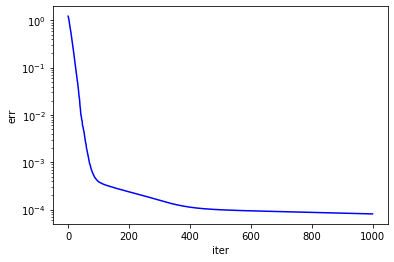

In [6]:
# exact value of energy in critical point
N = 2 * (3 ** num_of_layers) # number of spins
E0_exact_fin = -2 * (1 / np.sin(np.pi / (2 * N))) / N # exact energy

plt.yscale('log')
plt.xlabel('iter')
plt.ylabel('err')
plt.plot(E_list - tf.convert_to_tensor(([E0_exact_fin] * len(E_list))), 'b')
print("MERA energy:", E_list[-1].numpy())
print("Exact energy:", E0_exact_fin)